In [1]:
%matplotlib inline

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
plt.style.use('ggplot')
pd.set_option('display.max_columns', 100) 


from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import metrics
from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV, KFold

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, make_scorer

from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor

from sklearn.svm import SVR

import pickle
import os

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

<h3><center>Roller coaster speed prediction</center></h3>

## Table of Contents
* [Project objectives](#section_1_1)
* [Data sources](#section_2_1)
* [Data preparation](#section_3_1)
    * [Basic understanding](#section_3_2)
    * [Initial preparation](#section_3_3)
    * [Work on the missing values](#section_3_4)
* [Exploratory Data Analysis ](#section_4_1)
* [Common functions and plots ](#section_4_10)
* [Building models ](#section_5_1)
    * [RandomForestRegressor - default model](#section_5_2)
    * [RandomForestRegressor - tuning](#section_5_3)
    * [RandomForestRegressors and Lasso stack](#section_5_4)
    * [SVR - Default model](#section_6_1)
    * [SVR - tunned model](#section_6_2)
    * [Extreme Gradient Boosting](#section_7_1)
* [Models assessment ](#section_11_1)
* [Resources ](#section_12_1)
* [Closing notes ](#section_13_1)

### Project objectives: <a class="anchor" id="section_1_1"></a>
* Get basic understanding of the data
* Find accurate approach to fill the missing data with realistic values
* Reveal insights regarding the hidden relationships in the dataset
* Find a model or combination of models that predict the target value with minimum MAE

### Data sources: <a class="anchor" id="section_2_1"></a>
* <a href="https://www.kaggle.com/datasets/robikscube/rollercoaster-database">Roller Coaster Database</a>

### Data preparation: <a class="anchor" id="section_3_1"></a>

#### Basic understanding: <a class="anchor" id="section_3_2"></a>

In [3]:
#Read the data
data = pd.read_csv('data/coaster_db.csv')

In [4]:
#Get a basic understanding of the features
data.head(2)

,coaster_name,Length,Speed,Location,Status,Opening date,Type,Manufacturer,Height restriction,Model,Height,Inversions,Lift/launch system,Cost,Trains,Park section,Duration,Capacity,G-force,Designer,Max vertical angle,Drop,Soft opening date,Fast Lane available,Replaced,Track layout,Fastrack available,Soft opening date.1,Closing date,Opened,Replaced by,Website,Flash Pass Available,Must transfer from wheelchair,Theme,Single rider line available,Restraint Style,Flash Pass available,Acceleration,Restraints,Name,year_introduced,latitude,longitude,Type_Main,opening_date_clean,speed1,speed2,speed1_value,speed1_unit,speed_mph,height_value,height_unit,height_ft,Inversions_clean,Gforce_clean
0,Switchback Railway,600 ft (180 m),6 mph (9.7 km/h),Coney Island,Removed,"June 16, 1884",Wood,LaMarcus Adna Thompson,NaN,Lift Packed,50 ft (15 m),NaN,gravity,NaN,NaN,Coney Island Cyclone Site,1:00,1600 riders per hour,2.9,LaMarcus Adna Thompson,30°,43 ft (13 m),NaN,NaN,NaN,Gravity pulled coaster,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1884,40.574,-73.978,Wood,1884-06-16,6 mph,9.7 km/h,6.0,mph,6.0,50.0,ft,NaN,0,2.9
1,Flip Flap Railway,NaN,NaN,Sea Lion Park,Removed,1895,Wood,Lina Beecher,NaN,NaN,NaN,1.0,NaN,NaN,a single car. Riders are arranged 1 across in ...,NaN,NaN,NaN,12,Lina Beecher,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1895,40.578,-73.979,Wood,1895-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,12.0


The data in its original shape contains 1087 observations and 56 features regarding Roller Coasters. As not all features are directly related to our future target values, we will perform subsetting a little later.

#### Initial preparation: <a class="anchor" id="section_3_3"></a>

Looking at the columns and values we see that the type of "Length" column is a string (object), but it contains a number that might be related to the target values (speed). To test the hypothesis we will extract the numeric value from the sting

In [5]:
data['Length_ex'] = data['Length'].str.extract('(^\d*,?\d*)', expand=True)
data['Length_ex'] = pd.to_numeric(data['Length_ex'].str.replace(',',''))

In [6]:
data.columns

Index(['coaster_name', 'Length', 'Speed', 'Location', 'Status', 'Opening date',
       'Type', 'Manufacturer', 'Height restriction', 'Model', 'Height',
       'Inversions', 'Lift/launch system', 'Cost', 'Trains', 'Park section',
       'Duration', 'Capacity', 'G-force', 'Designer', 'Max vertical angle',
       'Drop', 'Soft opening date', 'Fast Lane available', 'Replaced',
       'Track layout', 'Fastrack available', 'Soft opening date.1',
       'Closing date', 'Opened', 'Replaced by', 'Website',
       'Flash Pass Available', 'Must transfer from wheelchair', 'Theme',
       'Single rider line available', 'Restraint Style',
       'Flash Pass available', 'Acceleration', 'Restraints', 'Name',
       'year_introduced', 'latitude', 'longitude', 'Type_Main',
       'opening_date_clean', 'speed1', 'speed2', 'speed1_value', 'speed1_unit',
       'speed_mph', 'height_value', 'height_unit', 'height_ft',
       'Inversions_clean', 'Gforce_clean', 'Length_ex'],
      dtype='object')

Now we will select columns that based on an intuition are related to the target. In addition, we will set more appropriate names and reorder the columns.

In [7]:
data = data[['Type', 'Length_ex', 'Inversions_clean', 
             'height_ft', 'speed_mph', 'Gforce_clean', 'year_introduced']].copy()
data = data.rename(columns = {"year_introduced": "year", "Type": "type", "Length_ex": "length",
                             "Inversions_clean": "inversions", "height_ft": "height", "speed_mph": "speed",
                             "Gforce_clean": "gforce", })

Dtypes will provide information on the data types we will working with.

In [8]:
data.dtypes

type           object
length        float64
inversions      int64
height        float64
speed         float64
gforce        float64
year            int64
dtype: object

At this point we have one column of object type. Since <i>data['type'].values_counts()</i> shows quiet a large number of variations, would like to consolidate all subtypes to 3 main types: Wood, Steel and Other

In [9]:
data.loc[data['type'].str.contains('steel', case=False), 'type'] = 'steel'
data.loc[data['type'].str.contains('wood', case=False), 'type'] = 'wood'
data.loc[data['type'].str.contains('other', case=False), 'type'] = 'other'

In [10]:
data['type_main'] = data['type']

The work on the type column continues with one hot encoding. We will use pandas to achieve that goal.

In [11]:
data = pd.get_dummies(data, columns = ['type'], dtype=int) 

In [12]:
data.dtypes, data.shape

(length        float64
 inversions      int64
 height        float64
 speed         float64
 gforce        float64
 year            int64
 type_main      object
 type_other      int64
 type_steel      int64
 type_wood       int64
 dtype: object,
 (1087, 10))

At this stage, we have 1087 observatins and 10 features. All of them are numeric. We can now proceed and check for missing values inside the data.

In [13]:
data.isna().sum()

length        134
inversions      0
height        916
speed         150
gforce        725
year            0
type_main       0
type_other      0
type_steel      0
type_wood       0
dtype: int64

#### Work on the missing values: <a class="anchor" id="section_3_4"></a>

Generally there are two main ways to handle the missing values. We can either drop or fill them with the mean  of the feature those values belongs to. Setting mean value may not necessarily reflect the real world situation, but droping all those values will decrease drastically the number of observations which in turn may affect the process of model development and training. In this project we will act a little differently to achieve more realistic results. <br>
* <b>Stage one</b>: Find the mean ratio between length and height and fill the values in length if values in height are present. Once done, we will reverse the logic and fill height if length is present. This operation will close the majority of gaps in length and height columns. Once this is done, we will proceed with stage two.
* <b>Stage two</b>: In this step we will use KNNimputer to determine the rest of the missing values. This approach follows the previously applied logic that aims more relism in the final results.
* <b>Stage three</b>: The final step aims to find possible relations between 'length', 'inversions', 'height', 'speed' and predict 'gforce'. The predictions will be stored in 'missing_gforce' and will be inserted if the original gorce value is missing.

<b>Stage 1: find the ratio between length and height and will the missing values</b>

In [14]:
# Work on the missing values - Stage 1
average_ratio = (data['length'] / data['height']).mean()
def impute_missing_length(row):
    if pd.isna(row['length']) and not pd.isna(row['height']):
        return row['height'] * average_ratio
    else:
        return row['length']

# Apply the impute_missing_values function to each row
data['length'] = data.apply(impute_missing_length, axis=1)

def impute_missing_height(row):
    if pd.isna(row['height']) and not pd.isna(row['length']):
        return row['length'] / average_ratio
    else:
        return row['height']

# Apply the impute_missing_values function to each row
data['height'] = data.apply(impute_missing_height, axis=1)

<b>Stage 2: Using KNNimputer we will find the missing values.</b></br>
KNNimputer General information: This is a scikit-learn class used to fill out or predict the missing values in a dataset. It is a more useful method which works on the basic approach of the KNN algorithm rather than the naive approach of filling all the values with mean or the median. In this approach, we specify a distance from the missing values which is also known as the K parameter. The missing value will be predicted in reference to the mean of the neighbours.

In [15]:
# Work on the missing values - Stage 2
fea_transformer = KNNImputer(n_neighbors=5)
data['length'] = fea_transformer.fit_transform(data[['length']])
data['height'] = fea_transformer.fit_transform(data[['height']])
data['speed'] = fea_transformer.fit_transform(data[['speed']])
# data['gforce'] = fea_transformer.fit_transform(data[['gforce']])

<b>Stage 3: Predict gforce using LinearRegression</b>

In [16]:
gforce_calc_df = data.dropna(subset=['gforce'])

# Fit a regression model
model = LinearRegression()
model.fit(gforce_calc_df[['length', 'inversions', 'height', 'speed']], gforce_calc_df['gforce'])

# Predict missing 'gforce' values
missing_gforce = model.predict(data[data['gforce'].isnull()][['length', 'inversions', 'height', 'speed']])
data.loc[data['gforce'].isnull(), 'gforce'] = missing_gforce

In [17]:
data

,length,inversions,height,speed,gforce,year,type_main,type_other,type_steel,type_wood
0,600.000000,0,71.307779,6.000000,2.900000,1884,wood,0,0,1
1,2126.752043,1,255.629057,48.617289,12.000000,1895,wood,0,0,1
2,2126.752043,0,255.629057,48.617289,3.476463,1896,other,1,0,0
3,2126.752043,1,255.629057,48.617289,3.607369,1901,steel,0,1,0
4,2126.752043,1,255.629057,48.617289,3.607369,1901,steel,0,1,0
...,...,...,...,...,...,...,...,...,...,...
1082,3444.000000,3,409.306653,53.000000,4.700000,2022,steel,0,1,0
1083,3328.000000,2,395.520482,73.000000,4.288994,2022,steel,0,1,0
1084,3169.000000,0,376.623921,59.300000,4.000000,2022,steel,0,1,0
1085,770.000000,0,91.511650,34.000000,3.210836,2022,steel,0,1,0


Since the problem with missing values is addressed, we can now check if there are duplicate values in our dataset and remove them.

In [18]:
#Drop the duplicate values and reset the index
data = data.drop_duplicates()
data.reset_index(drop = True)

,length,inversions,height,speed,gforce,year,type_main,type_other,type_steel,type_wood
0,600.000000,0,71.307779,6.000000,2.900000,1884,wood,0,0,1
1,2126.752043,1,255.629057,48.617289,12.000000,1895,wood,0,0,1
2,2126.752043,0,255.629057,48.617289,3.476463,1896,other,1,0,0
3,2126.752043,1,255.629057,48.617289,3.607369,1901,steel,0,1,0
4,2126.752043,0,255.629057,48.617289,3.476463,1902,wood,0,0,1
...,...,...,...,...,...,...,...,...,...,...
1040,3444.000000,3,409.306653,53.000000,4.700000,2022,steel,0,1,0
1041,3328.000000,2,395.520482,73.000000,4.288994,2022,steel,0,1,0
1042,3169.000000,0,376.623921,59.300000,4.000000,2022,steel,0,1,0
1043,770.000000,0,91.511650,34.000000,3.210836,2022,steel,0,1,0


Before proceeding with exploratory data analysis, we can also gather some basic statistical information regarding the dataset

In [19]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
length,1045.0,2145.209514,1307.862741,70.0,1148.000000,2126.752043,2953.000000,7442.000000
inversions,1045.0,1.324402,2.032077,0.0,0.000000,0.000000,2.000000,14.000000
height,1045.0,257.756005,153.650410,13.1,137.980553,255.629057,351.309659,884.454155
speed,1045.0,48.859874,15.565220,5.0,40.000000,48.617289,55.900000,149.100000
gforce,1045.0,3.652081,0.707240,0.8,3.228110,3.571110,4.010339,12.000000
year,1045.0,1995.057416,23.414812,1884.0,1989.000000,2000.000000,2010.000000,2022.000000
type_other,1045.0,0.061244,0.239892,0.0,0.000000,0.000000,0.000000,1.000000
type_steel,1045.0,0.751196,0.432527,0.0,1.000000,1.000000,1.000000,1.000000
type_wood,1045.0,0.187560,0.390547,0.0,0.000000,0.000000,0.000000,1.000000


# Exploratory Data Analysis <a class="anchor" id="section_4_1"></a>

Now that our data is reviewed and prepared, we can start exloring it. The aim of EDA is at better understanding of the data and finding patterns that would help build and traing accurate models .

Let's see how many roller coasters were introduced per year. We focus our attention on the top 10 years.

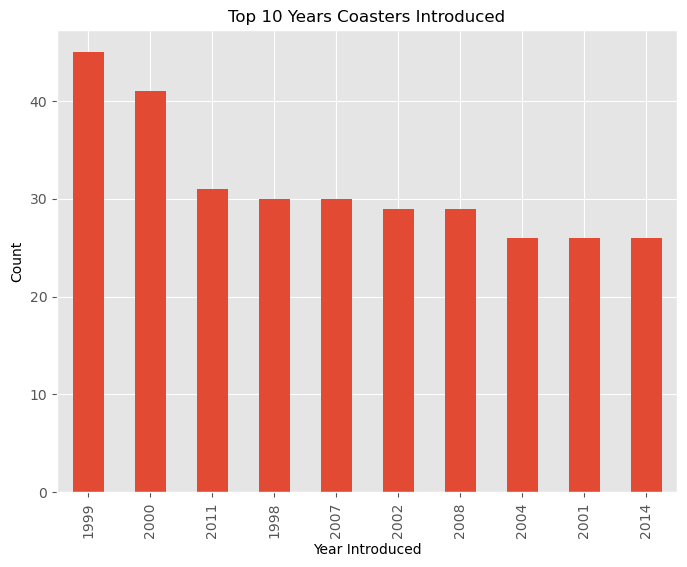

In [20]:
ax = data["year"].value_counts().head(10).plot(kind="bar", figsize=(8,6))
ax.set_title("Top 10 Years Coasters Introduced", fontsize=12)
ax.set_xlabel("Year Introduced", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
plt.show()

The distribution per type (material used for the construction) is also important.

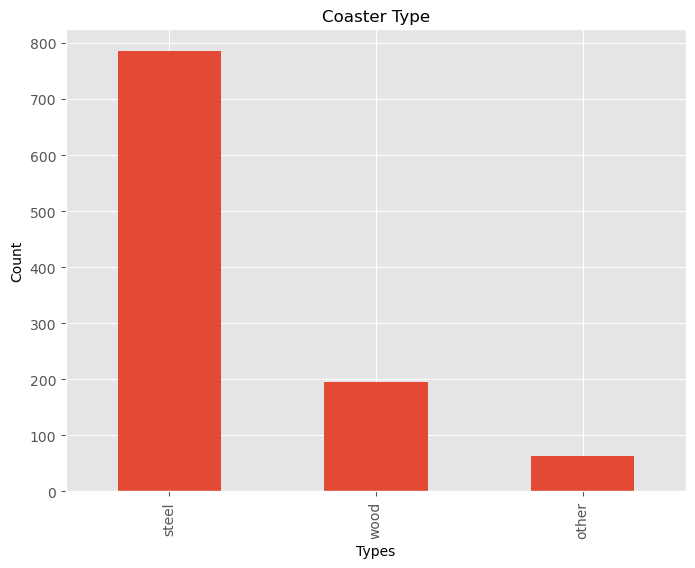

In [21]:
ax = data["type_main"].value_counts().plot(kind="bar", figsize=(8,6))
ax.set_title("Coaster Type", fontsize=12)
ax.set_xlabel("Types", fontsize=10)
ax.set_ylabel("Count", fontsize=10)
plt.show()

It is useful to check histogram of the Speed feature. It will be the target of our models. 

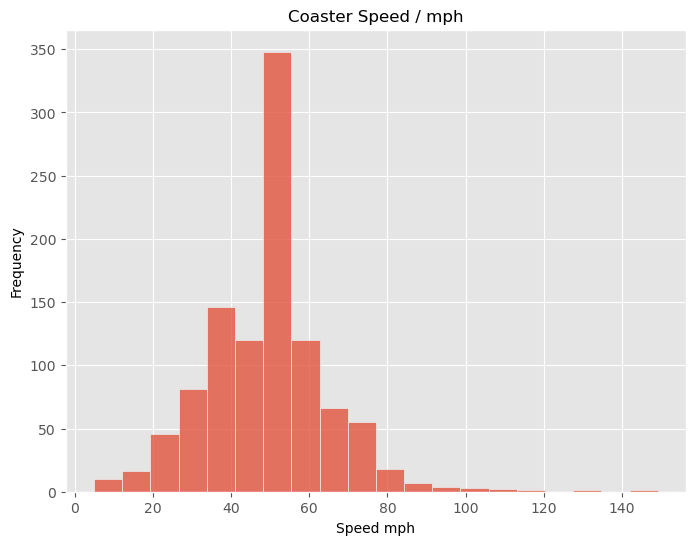

In [22]:
plt.figure(figsize=(8,6))
ax = sns.histplot(data=data, x="speed", bins=20)
ax.set_title("Coaster Speed / mph", fontsize=12)
ax.set_xlabel("Speed mph", fontsize=10)
ax.set_ylabel("Frequency", fontsize=10)
plt.show()

Using kernel density estimation (KDE) we can also estimate the probability density of the Speed column

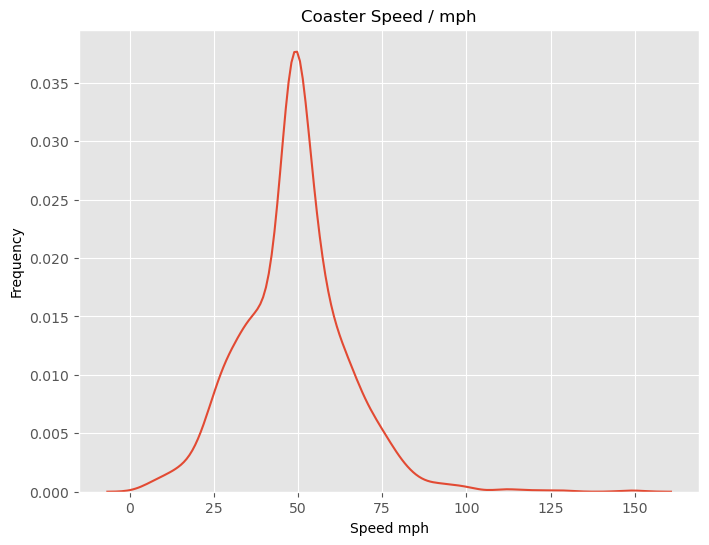

In [23]:
plt.figure(figsize=(8,6))
ax = sns.kdeplot(data=data, x="speed")
ax.set_title("Coaster Speed / mph", fontsize=12)
ax.set_xlabel("Speed mph", fontsize=10)
ax.set_ylabel("Frequency", fontsize=10)
plt.show()

Let's explore how the height and speed couple evolves over the years.

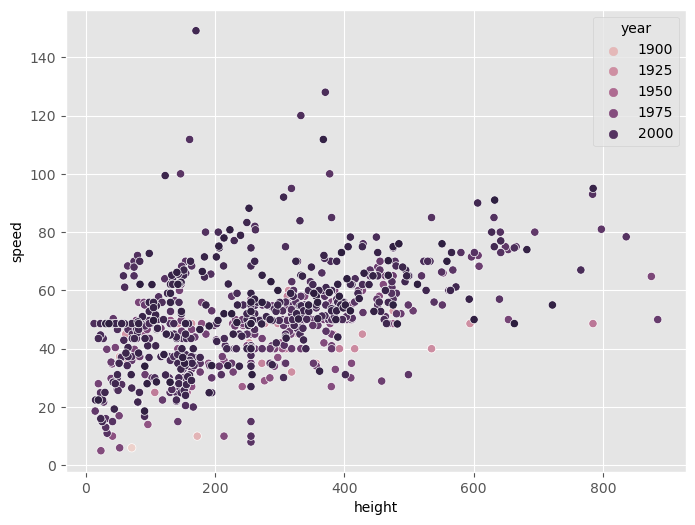

In [24]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(
    x="height",
    y="speed",
    data=data,
    hue="year",
)
plt.show()

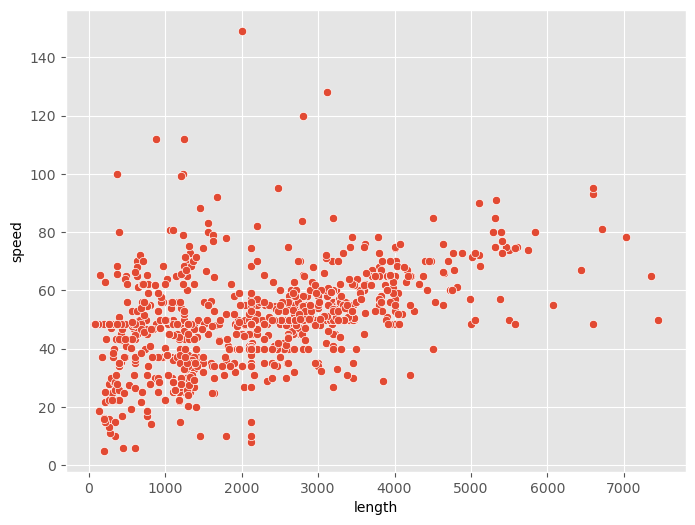

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

sns.scatterplot(
    x="length",
    y="speed",
    data=data,
)
plt.show()

We expect good correlation between Gforce and the target value. Let's see what the histrogram shows

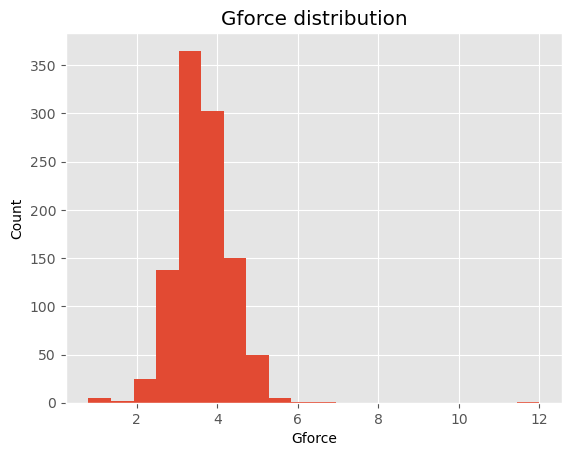

In [26]:
data["gforce"].plot(kind = "hist", \
                bins = 20, \
                title = "Gforce distribution")
plt.xlabel("Gforce")
plt.ylabel("Count")
plt.show()

We can also see how the speed changes over the years

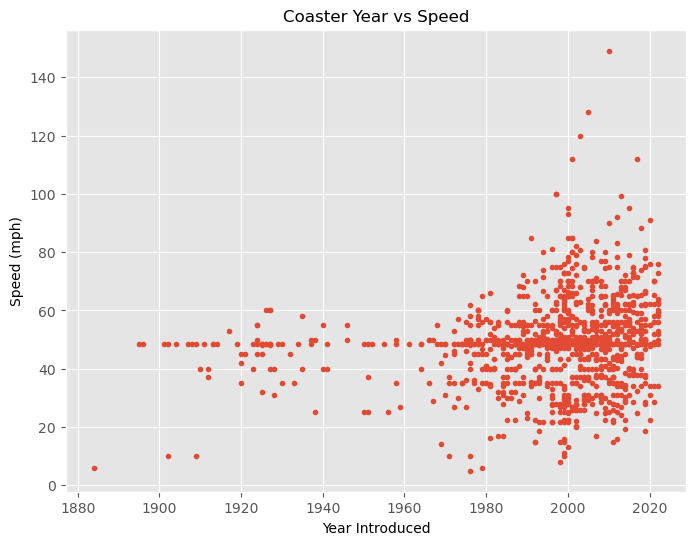

In [27]:
ax = data.plot(
    x="year",
    y="speed",
    figsize=(8, 6),
    style=".",
)
ax.set_title("Coaster Year vs Speed", fontsize=12)
ax.set_xlabel("Year Introduced")
ax.set_ylabel("Speed (mph)")
ax.legend().remove()
plt.show()

In [28]:
# We no longer need type_main column. It was added just to show the distribution per type
data = data.drop(['type_main'], axis = 1)

In [29]:
data

,length,inversions,height,speed,gforce,year,type_other,type_steel,type_wood
0,600.000000,0,71.307779,6.000000,2.900000,1884,0,0,1
1,2126.752043,1,255.629057,48.617289,12.000000,1895,0,0,1
2,2126.752043,0,255.629057,48.617289,3.476463,1896,1,0,0
3,2126.752043,1,255.629057,48.617289,3.607369,1901,0,1,0
5,2126.752043,0,255.629057,48.617289,3.476463,1902,0,0,1
...,...,...,...,...,...,...,...,...,...
1082,3444.000000,3,409.306653,53.000000,4.700000,2022,0,1,0
1083,3328.000000,2,395.520482,73.000000,4.288994,2022,0,1,0
1084,3169.000000,0,376.623921,59.300000,4.000000,2022,0,1,0
1085,770.000000,0,91.511650,34.000000,3.210836,2022,0,1,0


Now we can see how the features are related to each other

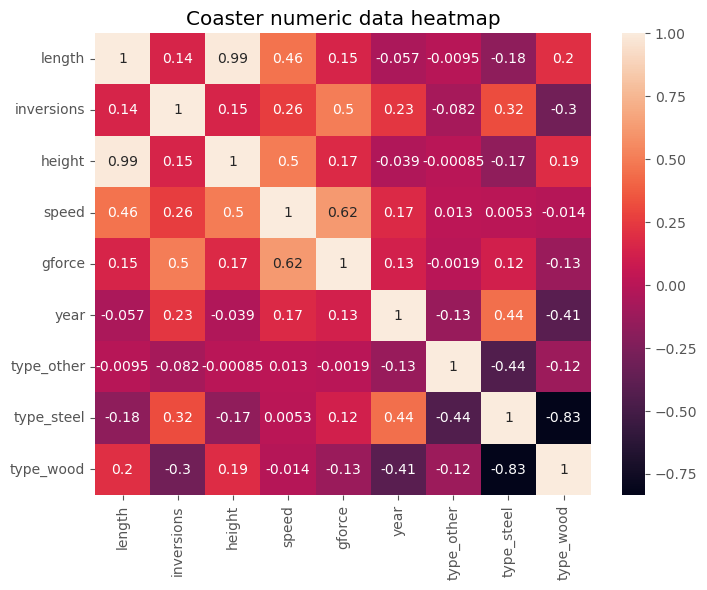

In [30]:
plt.figure(figsize = (8,6))
sns.heatmap(data[["length", "inversions", "height", "speed", "gforce", "year", \
                "type_other", "type_steel", "type_wood" ]].dropna().corr(), annot = True)
plt.title("Coaster numeric data heatmap")
plt.show()


In this matrix we see that features with stronger correlation with the target are <i>gforce</i>, followed by <i>length</i>, <i>height</i>, <i>inversions</i> and <i>year</i>.

The following are a couple of functions to automate the processes of ploting actual and predicted data and score calculations. Those are unified and will be used by any of the trained models.

# Common functions and plots <a class="anchor" id="section_4_10"></a>

In [31]:
def print_graph(y_test, y_pred):
    '''
    Plots predictions and actual values
    '''
    results = pd.DataFrame(zip(y_test, y_pred, y_test - y_pred), columns = ['y_test', 'y_pred', 'error'])
    results = results.sort_values(by='y_test')

    # Extract the sorted y_test and y_pred values
    y_test_sorted = results['y_test']
    y_pred_sorted = results['y_pred']

    # Plot the predictions
    plt.figure(figsize=(6, 4))
    plt.plot(range(len(y_test_sorted)), y_test_sorted, label='Actual', marker='o', linestyle='-')
    plt.plot(range(len(y_test_sorted)), y_pred_sorted, label='Predicted', marker='x', linestyle='--')
    plt.xlabel('Data Points')
    plt.ylabel('Target Values')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.show()


def calculate_scores(best_model, X, y):
    '''
    Calculates R^2, MAE, MSE and RMSE scores
    Returns:
    - r2, mae, mse, rmse, y_pred
    '''
    y_pred = best_model.predict(X)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = mse ** 0.5
    return r2, mae, mse, rmse, y_pred


def plot_learning_curve(estimator, X_train, y_train, param_space, cv, scoring=None):
    """
    Plot learning curves for a given estimator with hyperparameter tuning.
    Returns:
    - Plots the learning curves.
    """

    # Use learning_curve function to compute learning curves
    train_sizes, train_scores, validation_scores = learning_curve(
        estimator, X_train, y_train, cv=cv, train_sizes=np.linspace(0.1, 1.0, 10), scoring=scoring)

    # Compute mean and standard deviation for training and validation scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)
    validation_scores_std = np.std(validation_scores, axis=1)

    # Plot learning curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training Score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.15, color='blue')

    plt.plot(train_sizes, validation_scores_mean, label='Validation Score', color='green', marker='o')
    plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std,
                     validation_scores_mean + validation_scores_std, alpha=0.15, color='green')

    plt.title('Learning Curve')
    plt.xlabel('Number of Training Examples')
    plt.ylabel('MAE')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
def plot_residuals(y_test, y_pred):
    '''
    Plots the residuals to analyze their distribution
    '''
    residuals = y_test - y_pred
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, residuals, alpha=0.5)
    plt.xlabel("Actual Values")
    plt.ylabel("Residuals")
    plt.title("Residual Analysis")
    plt.axhline(0, color='blue', linestyle='--')
    plt.show()
    
def collect_data(*args):
    model = args[0]
    r2 = args[1]
    mae = args[2]
    mse = args[3]
    rmse = args[4]
    model_data = args[5]
    if not model in model_data:
        model_data[model] = []
    for metric in [r2, mae, mse, rmse]:
        model_data[model].append(round(metric, 2))
    return model_data


# Building models   <a class="anchor" id="section_5_1"></a>

## RandomForestRegressor - default model <a class="anchor" id="section_5_2"></a>

In [32]:
#Set random seed for all models
random_seed = 100

In [33]:
#Get a copy of the prepared dataset
rf_default_data = data.copy()

In [34]:
#Detect and remove potential outliers
upper_limit = rf_default_data["speed"].mean() + 3 * rf_default_data["speed"].std()
lower_limit = rf_default_data["speed"].mean() - 3 * rf_default_data["speed"].std()
rf_default_data = rf_default_data[(rf_default_data["speed"]\
                                   < upper_limit) & (rf_default_data["speed"] > lower_limit)]

In [35]:
#Prepare X and y for the model
X = rf_default_data.drop(["speed"], axis = 1)
y = rf_default_data["speed"]

In [36]:
#Scale the input data
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)

In [37]:
#Split the data to train and test sets
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=random_seed)

In [38]:
#Create a model, fit the data and make predictions
def_rf_regressor = RandomForestRegressor(random_state=random_seed)
def_rf_regressor.fit(X_train, y_train)
y_pred = def_rf_regressor.predict(X_test)

In [39]:
# Save the model
save_folder = 'trained_models'

os.makedirs(save_folder, exist_ok=True)

model_filename = os.path.join(save_folder, 'def_rf_regressor.pkl')

with open(model_filename, 'wb') as file:
    pickle.dump(def_rf_regressor, file)

R2: 0.8192786936142425, MAE: 3.8846924616205576, MSE: 40.80575474549076, RMSE: 6.387938223362117


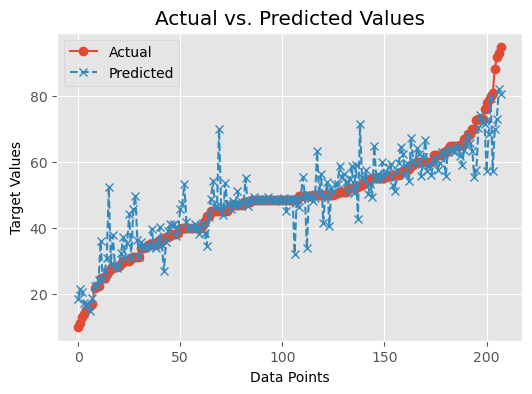

In [40]:
#Calculate scores and plot y and y_pred for the testing data
r2, mae, mse, rmse, y_pred = calculate_scores(def_rf_regressor, X_test, y_test)
model_metrics = collect_data("RF_def", r2, mae, mse, rmse, dict())
def_rf_regressor_data = []
print(f"R2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print_graph(y_test, y_pred) 

R2: 0.9737150092709957, MAE: 1.3817636104756505, MSE: 5.346398679154511, RMSE: 2.3122280768026564


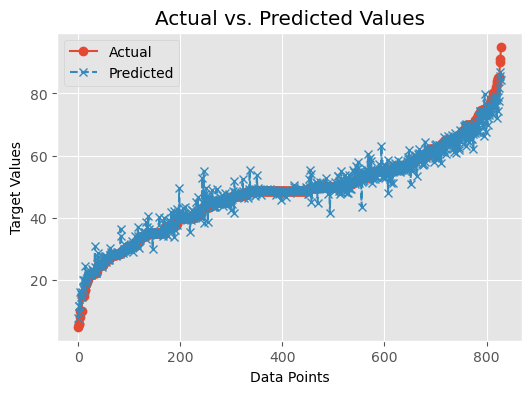

In [41]:
#Calculate scores and plot y and y_pred for the training data
r2, mae, mse, rmse, y_pred = calculate_scores(def_rf_regressor, X_train, y_train)
model_metrics = collect_data("RF_def", r2, mae, mse, rmse, model_metrics)
print(f"R2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print_graph(y_train, y_pred)

From the first test we see that the model learns the training data exceptionally well, but fails to generalize and the result of this is lower results on the testing data. This is called overfiting and shows that the default model has high variance. Before tuning it by applying regularization, let's check the feature importances which might be usefull for future improvements.

In [42]:
feature_importances = def_rf_regressor.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, feature_importances))
feature_importance_dict

{'length': 0.13151030707125944,
 'inversions': 0.04258769194341751,
 'height': 0.12616955927937437,
 'gforce': 0.616515156522356,
 'year': 0.06285752521068547,
 'type_other': 0.003151459032969293,
 'type_steel': 0.00981300999193713,
 'type_wood': 0.00739529094800082}

Here we see that inversions, type_other, type_steel and type_wood are not that important. Depending on the performancec of the tuned model, those features might be dropped. The parameters of the default model are somehow an entry point to the param_space of BayesSearchCV.   

In [43]:
def_rf_regressor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 100,
 'verbose': 0,
 'warm_start': False}

## RandomForestRegressor - tuning  <a class="anchor" id="section_5_3">

In [44]:
#Get a copy of the original data
rf_tune = data.copy()

In [45]:
#Detect and remove potential outliers
upper_limit = rf_tune["speed"].mean() + 3 * rf_tune["speed"].std()
lower_limit = rf_tune["speed"].mean() - 3 * rf_tune["speed"].std()
rf_tune = rf_tune[(rf_tune["speed"] < upper_limit) & (rf_tune["speed"] > lower_limit)]

In [46]:
#Prepare X and y for the model
X = rf_tune.drop(["speed"], axis = 1)
y = rf_tune["speed"]

In [47]:
#Scale the X
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)

In [48]:
#Split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=random_seed)

In [49]:
# Define the param search space for the RandomForestRegressor model.
param_space = {
    'n_estimators': Integer(75, 120),  
    'max_depth': Integer(1, 9),  
    'min_samples_split': [10, 11, 12, 13],   
    'min_samples_leaf': [ 4,5, 6, 7, 9],  
    'max_features': ['sqrt', 'log2'],  
    'bootstrap' : [True, False]
}

In [50]:
# Create the model itself.
rf_regressor = RandomForestRegressor(criterion='absolute_error', random_state=random_seed)

In [51]:
# Define KFold settings
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

In [52]:
# BayesSearchCV configuration
bayesian_search = BayesSearchCV(
    estimator=rf_regressor,
    search_spaces=param_space,
    n_iter=50,
    cv=kf,
    n_jobs=-1,
    random_state=random_seed,
    scoring='neg_mean_absolute_error',  # Optimize for negative MAE
    verbose = 0
)

In [53]:
#Fit the data
bayesian_search.fit(X_train, y_train)

BayesSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
              estimator=RandomForestRegressor(criterion='absolute_error',
                                              random_state=100),
              n_jobs=-1, random_state=100, scoring='neg_mean_absolute_error',
              search_spaces={'bootstrap': [True, False],
                             'max_depth': Integer(low=1, high=9, prior='uniform', transform='normalize'),
                             'max_features': ['sqrt', 'log2'],
                             'min_samples_leaf': [4, 5, 6, 7, 9],
                             'min_samples_split': [10, 11, 12, 13],
                             'n_estimators': Integer(low=75, high=120, prior='uniform', transform='normalize')})

In [54]:
#Get params and best model
best_params = bayesian_search.best_params_
best_rf_regressor = bayesian_search.best_estimator_

In [55]:
# Make a prediction
y_pred = best_rf_regressor.predict(X_test)

In [56]:
# Save the model
save_folder = 'trained_models'

os.makedirs(save_folder, exist_ok=True)

model_filename = os.path.join(save_folder, 'best_rf_regressor.pkl')

with open(model_filename, 'wb') as file:
    pickle.dump(best_rf_regressor, file)

In [57]:
best_params

OrderedDict([('bootstrap', False),
             ('max_depth', 9),
             ('max_features', 'log2'),
             ('min_samples_leaf', 4),
             ('min_samples_split', 10),
             ('n_estimators', 93)])

R2: 0.7809170643305857, MAE: 4.451776221649616, MSE: 49.46757369474612, RMSE: 7.033318825045977


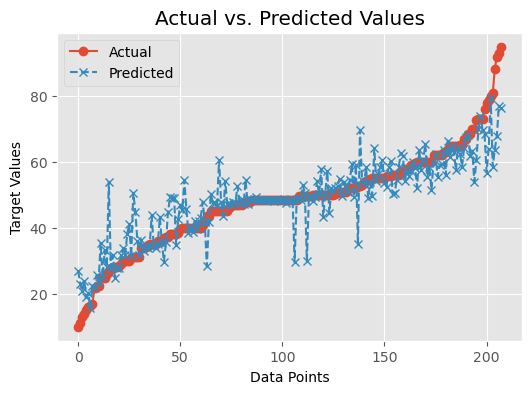

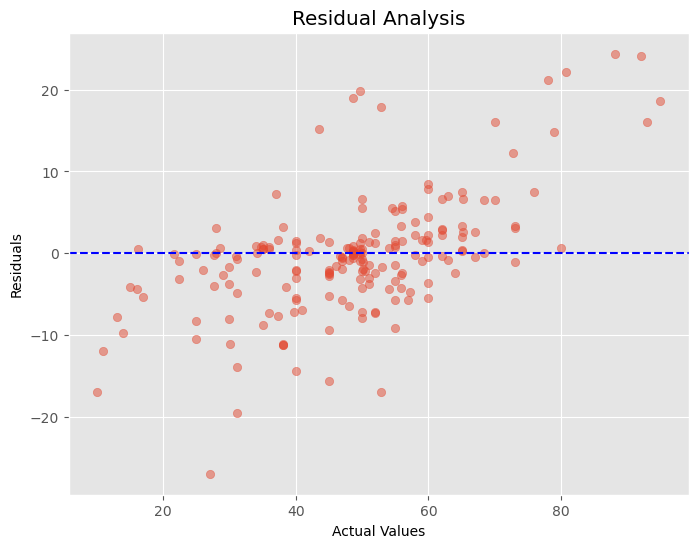

In [58]:
#Calculate scores and plot y and y_pred for the testing data
r2, mae, mse, rmse, y_pred = calculate_scores(best_rf_regressor, X_test, y_test)
model_metrics = collect_data("RF_tune", r2, mae, mse, rmse, model_metrics)
print(f"R2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print_graph(y_test, y_pred)
plot_residuals(y_test, y_pred)

R2: 0.8617189367363086, MAE: 3.041205334631676, MSE: 28.126534325511223, RMSE: 5.303445514522726


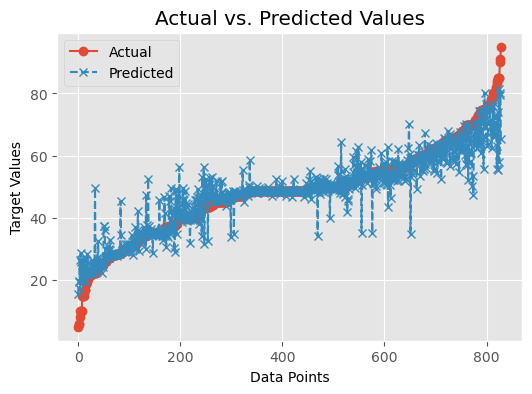

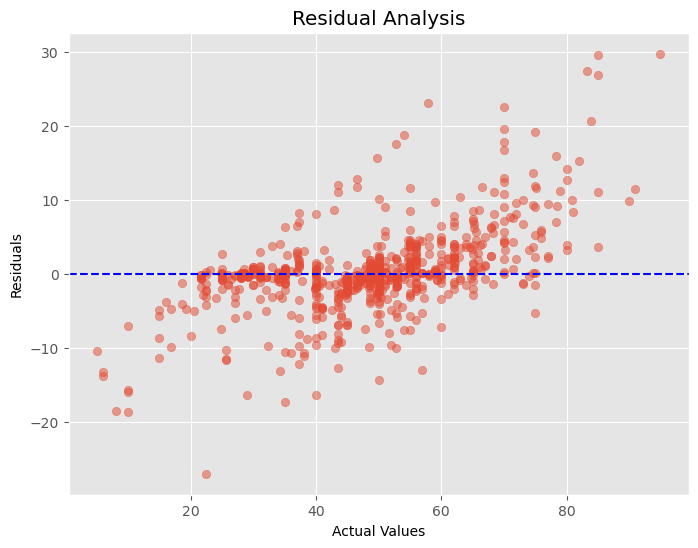

In [59]:
#Calculate scores and plot y and y_pred for the training data
r2, mae, mse, rmse, y_pred = calculate_scores(best_rf_regressor, X_train, y_train)
model_metrics = collect_data("RF_tune", r2, mae, mse, rmse, model_metrics)
print(f"R2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print_graph(y_train, y_pred)
plot_residuals(y_train, y_pred)

Comparing the MAE gaps of the default and tuned RandomForestRegressors, we see that it dropped from 2.6 to 1.41. Having this in mind, we can say that the tuned model performs better than the default one. The latter generalizes better.

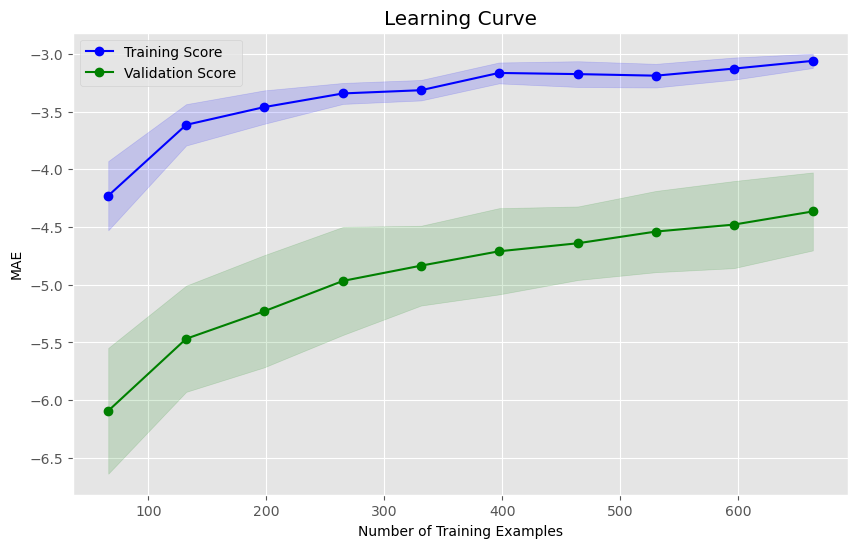

In [60]:
plot_learning_curve(best_rf_regressor, X_train, y_train, param_space, cv=kf, scoring='neg_mean_absolute_error')

# RandomForestRegressors and LASSO stack  <a class="anchor" id="section_5_4">

While looking at the performance of the default RandomForestRegressor we saw that the importrance of some features is not significant. Now lets prepare a stack where one of the base models will be LASSO. The intention here is to introduce a little bias and also get advantage of potential feature selection,

In [61]:
#Get a copy of the original data
rf_lasso_tune = data.copy()

In [62]:
#Detect and remove potential outliers
upper_limit = rf_lasso_tune["speed"].mean() + 3 * rf_lasso_tune["speed"].std()
lower_limit = rf_lasso_tune["speed"].mean() - 3 * rf_lasso_tune["speed"].std()
rf_lasso_tune = rf_lasso_tune[(rf_lasso_tune["speed"] < upper_limit) & (rf_lasso_tune["speed"] > lower_limit)]

In [63]:
#Prepare X and y for the model
X = rf_lasso_tune.drop(["speed"], axis = 1)
y = rf_lasso_tune["speed"]

In [64]:
#Scale the X
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)

In [65]:
#Split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=random_seed)

In [66]:
#Param space for RandomForest
param_space_random_forest = {
    'n_estimators': Integer(150, 300),
    'max_depth': Integer(1, 7),  # Maximum depth of each tree
    'min_samples_split': [10, 11, 12, 13], #ust the range for min_samples_split
    'min_samples_leaf': [8, 9], #djust the range for min_samples_leaf
    'max_features': ['sqrt', 'log2'],  # Number of features to consider when looking for the best split
    'bootstrap' : [True, False]
}

In [67]:
#Param space for lasso
param_space_lasso = {
    'alpha': (0.1 ,100)
}

In [68]:
# K-Fold object and settings:
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

In [69]:
#BayesSearchCV for the base models
bayesian_search_random_forest = BayesSearchCV(
    RandomForestRegressor(random_state=random_seed),
    param_space_random_forest,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=kf,

)

bayesian_search_lasso = BayesSearchCV(
    Lasso(),
    param_space_lasso,
    n_iter=50,
    scoring='neg_mean_absolute_error',
    cv=kf,

)

In [70]:
# Fit the data:
bayesian_search_random_forest.fit(X_train, y_train)
bayesian_search_lasso.fit(X_train, y_train)

# Get the best params and the best estimator for both base models:
best_params_random_forest = bayesian_search_random_forest.best_params_
best_estimator_random_forest = bayesian_search_random_forest.best_estimator_

best_params_lasso = bayesian_search_lasso.best_params_
best_estimator_lasso = bayesian_search_lasso.best_estimator_

In [71]:
# Create the base models with the best params:
base_models = [
    ('random_forest', best_estimator_random_forest),
    ('lasso', best_estimator_lasso)
    
]

In [72]:
# Specify params for the Lasso final_estimator
final_estimator = Lasso(random_state=random_seed) # You can set the alpha parameter as needed

# Create the stacking model with Lasso  
stacking_regressor = StackingRegressor(estimators=base_models, final_estimator=final_estimator)

# Fit  the training data:
stacking_regressor.fit(X_train, y_train)

# Make predictions 
y_pred = stacking_regressor.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
# print(f"Best Stacking MAE: {mae}")

In [73]:
# Save the model
save_folder = 'trained_models'

os.makedirs(save_folder, exist_ok=True)

model_filename = os.path.join(save_folder, 'stacking_regressor.pkl')

with open(model_filename, 'wb') as file:
    pickle.dump(stacking_regressor, file)

R2: 0.7739591765101057, MAE: 4.691095220108755, MSE: 51.03862178878269, RMSE: 7.144131982878164


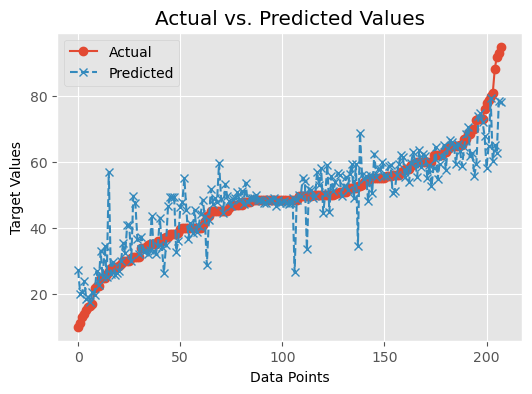

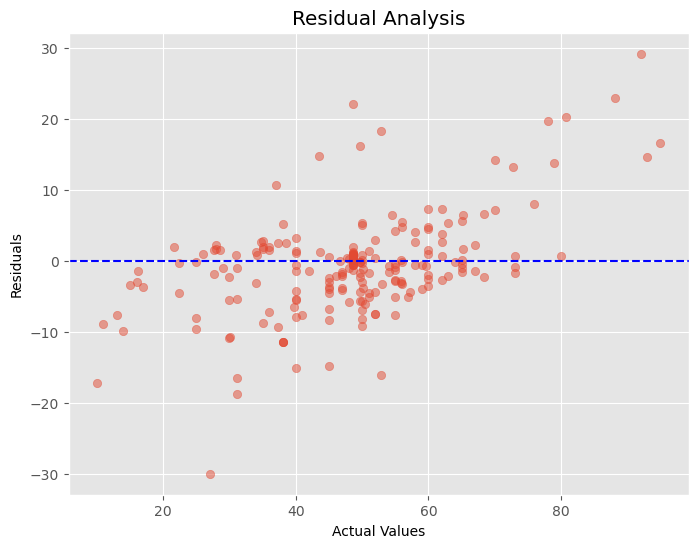

In [74]:
#Calculate scores and plot y and y_pred for the testing data
r2, mae, mse, rmse, y_pred = calculate_scores(stacking_regressor, X_test, y_test)
model_metrics = collect_data("RF_LASSO", r2, mae, mse, rmse, model_metrics)
print(f"R2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print_graph(y_test, y_pred) 
plot_residuals(y_test, y_pred)

R2: 0.8436075841719831, MAE: 3.7006076263560246, MSE: 31.81040518648755, RMSE: 5.640071381329101


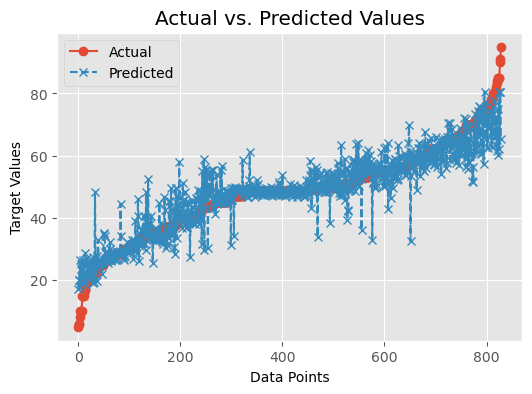

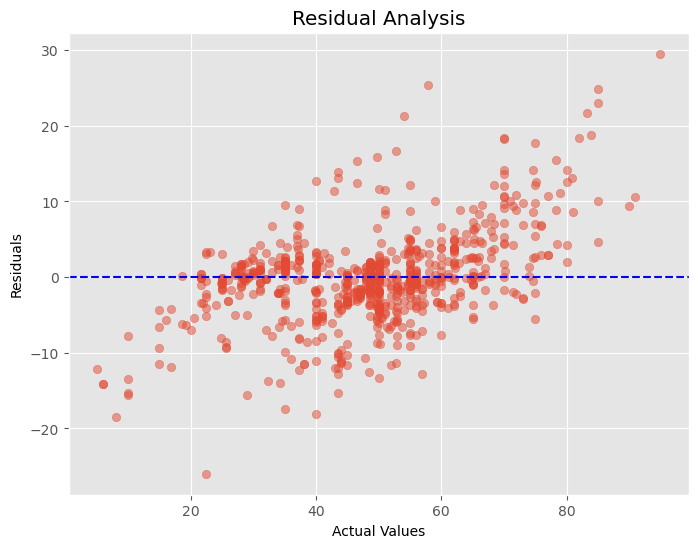

In [75]:
#Calculate scores and plot y and y_pred for the training data
r2, mae, mse, rmse, y_pred = calculate_scores(stacking_regressor, X_train, y_train)
model_metrics = collect_data("RF_LASSO", r2, mae, mse, rmse, model_metrics)
print(f"R2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print_graph(y_train, y_pred)
plot_residuals(y_train, y_pred)

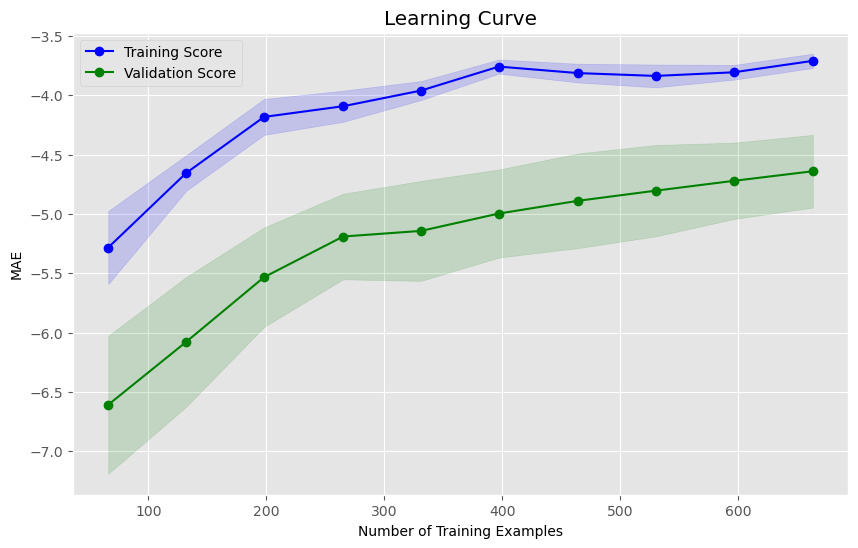

In [76]:
plot_learning_curve(stacking_regressor, X_train, y_train, param_space, cv=kf, scoring='neg_mean_absolute_error')

With this experiment we saw that the MAE gap is closed a little more. While the gap of the tuned RandomForest model was 1.41, the stacked model decreases it to 0.98 while keeping the other metrics fairly similar.

# SVR - Default model  <a class="anchor" id="section_6_1">

It would also be interesting to see how SVR performs on this dataset. In the tuned version will be try with both linear and non-linear kernels. With non-linear kernels we will try to capture more intricate patterns in the data.

In [77]:
#Get a copy of the original data
svr_default = data.copy()

In [78]:
#Detect and remove potential outliers
upper_limit = svr_default["speed"].mean() + 3 * svr_default["speed"].std()
lower_limit = svr_default["speed"].mean() - 3 * svr_default["speed"].std()
svr_default = svr_default[(svr_default["speed"] < upper_limit) & (svr_default["speed"] > lower_limit)]

In [79]:
#Prepare X and y for the model
X = svr_default.drop(["speed"], axis = 1)
y = svr_default["speed"]

In [80]:
#Scale the X
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)

In [81]:
#Split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=random_seed)

In [82]:
#Create the default model
svr_default_model = SVR()

In [83]:
#Fit and predict
svr_default_model.fit(X_train, y_train)
y_pred = svr_default_model.predict(X_test)

In [84]:
# Save the model
save_folder = 'trained_models'

os.makedirs(save_folder, exist_ok=True)

model_filename = os.path.join(save_folder, 'svr_default_model.pkl')

with open(model_filename, 'wb') as file:
    pickle.dump(svr_default_model, file)

R2: 0.40409020950527275, MAE: 8.463095744238974, MSE: 134.5527500197453, RMSE: 11.599687496641678


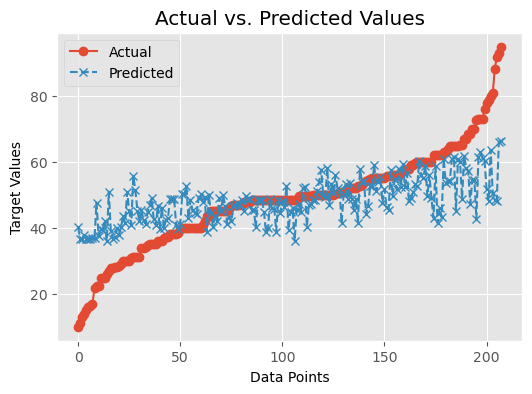

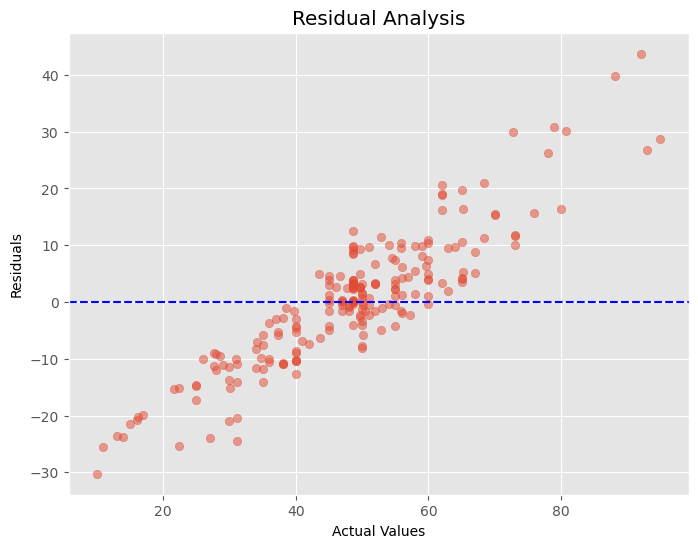

In [85]:
#Calculate score for testing data
r2, mae, mse, rmse, y_pred = calculate_scores(svr_default_model, X_test, y_test)
model_metrics = collect_data("SVR_def", r2, mae, mse, rmse, model_metrics)
print(f"R2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print_graph(y_test, y_pred) 
plot_residuals(y_test, y_pred)

R2: 0.39553933780279704, MAE: 8.090030651365574, MSE: 122.94802457000593, RMSE: 11.08819302546659


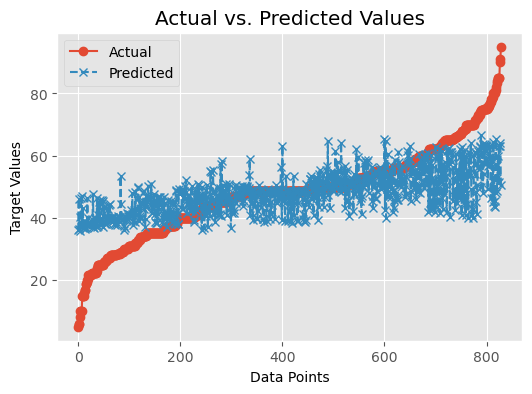

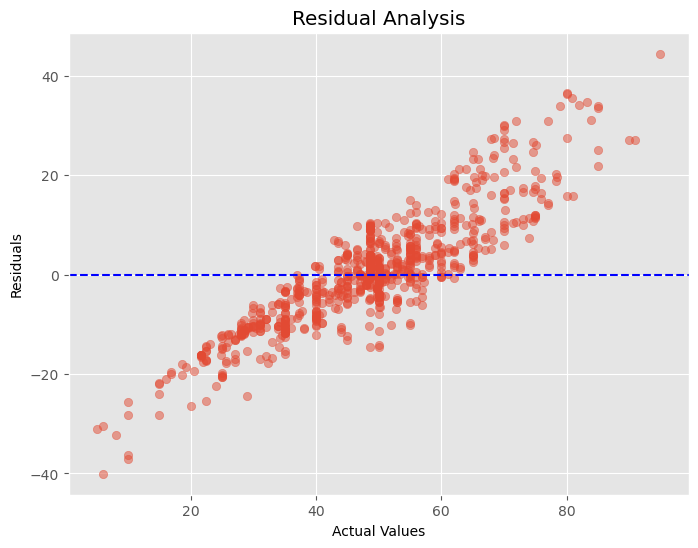

In [86]:
#Calculate score for training data
r2, mae, mse, rmse, y_pred = calculate_scores(svr_default_model, X_train, y_train)
model_metrics = collect_data("SVR_def", r2, mae, mse, rmse, model_metrics)
print(f"R2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print_graph(y_train, y_pred)
plot_residuals(y_train, y_pred)

It looks like this default model does not perform well. Now let's see if after tuning, its performance would increase.

# SVR - tunned model  <a class="anchor" id="section_6_2">

In [87]:
#Get a copy of the original data
svr_tune_data = data.copy()

In [88]:
svr_tune_data

,length,inversions,height,speed,gforce,year,type_other,type_steel,type_wood
0,600.000000,0,71.307779,6.000000,2.900000,1884,0,0,1
1,2126.752043,1,255.629057,48.617289,12.000000,1895,0,0,1
2,2126.752043,0,255.629057,48.617289,3.476463,1896,1,0,0
3,2126.752043,1,255.629057,48.617289,3.607369,1901,0,1,0
5,2126.752043,0,255.629057,48.617289,3.476463,1902,0,0,1
...,...,...,...,...,...,...,...,...,...
1082,3444.000000,3,409.306653,53.000000,4.700000,2022,0,1,0
1083,3328.000000,2,395.520482,73.000000,4.288994,2022,0,1,0
1084,3169.000000,0,376.623921,59.300000,4.000000,2022,0,1,0
1085,770.000000,0,91.511650,34.000000,3.210836,2022,0,1,0


In [89]:
#Detect and remove potential outliers
upper_limit = svr_tune_data["speed"].mean() + 3 * svr_tune_data["speed"].std()
lower_limit = svr_tune_data["speed"].mean() - 3 * svr_tune_data["speed"].std()
svr_tune_data = svr_tune_data[(svr_tune_data["speed"] < upper_limit) & (svr_tune_data["speed"] > lower_limit)]

In [90]:
#Prepare X and y for the model
X = rf_tune.drop(["speed"], axis = 1)
y = rf_tune["speed"]

In [91]:
#Scale the X
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)

In [92]:
#Split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=random_seed)

In [93]:
#Create the default model
svr_tune = SVR()

In [94]:
# Define the parameter search space
param_space = {
    'C': (1e-3, 1e+3, 'log-uniform'),
    'epsilon': (1e-3, 1e-1, 'log-uniform'),
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

In [95]:
#Set KFold and BayesSearchCV
kf = KFold(n_splits=3, shuffle=True, random_state=random_seed)
bayes_cv = BayesSearchCV(
    svr_tune,
    param_space,
    n_iter=50,  # Number of iterations for the search
    cv=kf,  # K-fold cross-validation
    scoring='neg_mean_absolute_error',  # Optimize for MAE
    random_state=random_seed,  # Set a random seed for reproducibility
    n_jobs=-1,  # Use all available CPU cores for faster optimization
)

In [96]:
#Fit and get params and estimator
bayes_cv.fit(X_train, y_train)
best_params = bayes_cv.best_params_
best_svr = bayes_cv.best_estimator_

In [97]:
#Make prediction
y_pred = best_svr.predict(X_test)

In [98]:
# Save the model
save_folder = 'trained_models'

os.makedirs(save_folder, exist_ok=True)

model_filename = os.path.join(save_folder, 'best_svr.pkl')

with open(model_filename, 'wb') as file:
    pickle.dump(best_svr, file)

R2: 0.6933295952685994, MAE: 5.321770659490052, MSE: 69.24428321948064, RMSE: 8.321314993405828


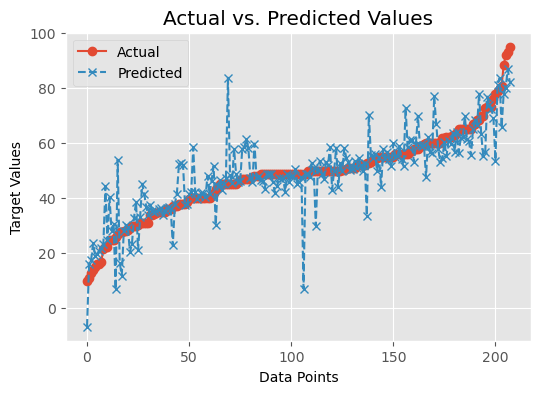

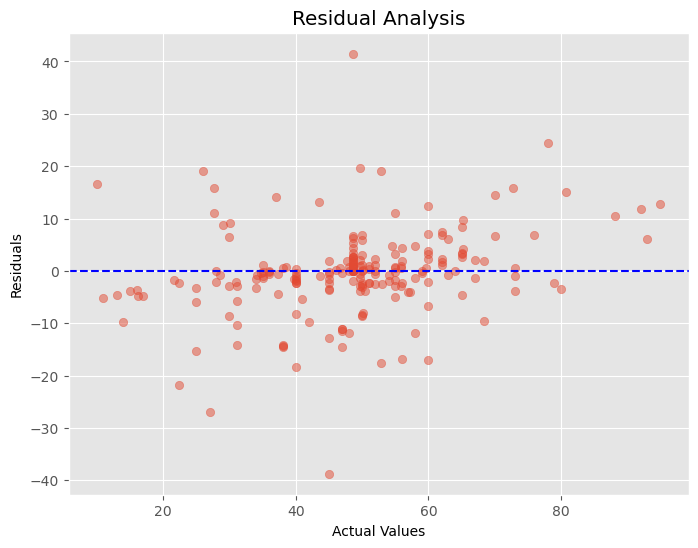

In [99]:
r2, mae, mse, rmse, y_pred = calculate_scores(best_svr, X_test, y_test)
model_metrics = collect_data("SVR_tune", r2, mae, mse, rmse, model_metrics)
print(f"R2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print_graph(y_test, y_pred) 
plot_residuals(y_test, y_pred)

R2: 0.6439532002027721, MAE: 5.0647492381645955, MSE: 72.42034664492368, RMSE: 8.510014491463789


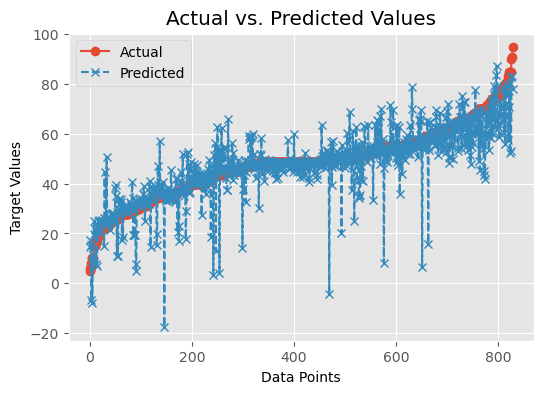

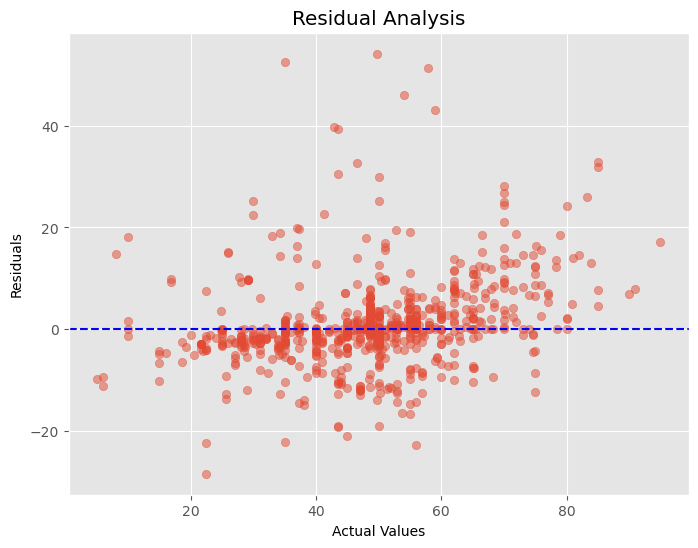

In [100]:
r2, mae, mse, rmse, y_pred = calculate_scores(best_svr, X_train, y_train)
model_metrics = collect_data("SVR_tune", r2, mae, mse, rmse, model_metrics)
print(f"R2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print_graph(y_train, y_pred)
plot_residuals(y_train, y_pred)

The performance of the tuned SVR is way better than the default model, but compared to the above stacked model is still weaker.

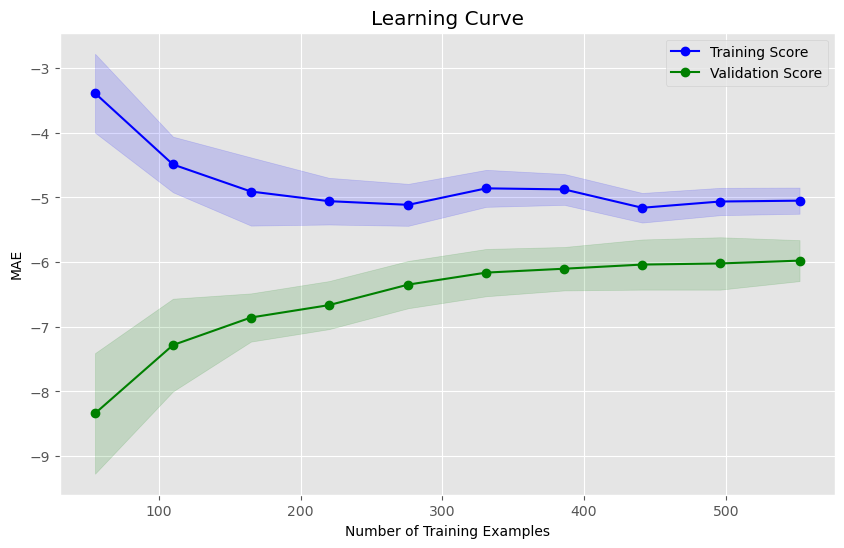

In [101]:
plot_learning_curve(best_svr, X_train, y_train, param_space, cv=kf, scoring='neg_mean_absolute_error')

# Extreme Gradient Boosting <a class="anchor" id="section_7_1">

In [102]:
#Get a copy of the original data
xgb_tune = data.copy()

In [103]:
#Detect and remove potential outliers
upper_limit = xgb_tune["speed"].mean() + 3 * xgb_tune["speed"].std()
lower_limit = xgb_tune["speed"].mean() - 3 * xgb_tune["speed"].std()
xgb_tune = xgb_tune[(xgb_tune["speed"] < upper_limit) & (xgb_tune["speed"] > lower_limit)]

In [104]:
#Prepare X and y for the model
X = xgb_tune.drop(["speed"], axis = 1)
y = xgb_tune["speed"]

In [105]:
#Scale the X
scaler = MinMaxScaler()
x_scaled = scaler.fit_transform(X)

In [106]:
#Split the data to training and testing set
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=random_seed)

In [107]:
param_space = {
    'xgb__n_estimators': Integer(30, 130),
    'xgb__max_depth': Integer(2, 4),
    'xgb__learning_rate': Real(0.01, 0.07, 'log-uniform'),
    'xgb__min_child_weight': Integer(3, 10),
    'xgb__gamma': Real(0, 1),  
    'xgb__reg_alpha': Real(0, 2),
    'xgb__reg_lambda': Real(0, 2), 
    'xgb__objective': ['reg:linear'],
    'xgb__booster': ['gbtree'],
    'xgb__subsample': Real(0.95, 1),
    'xgb__colsample_bytree': Real(0.75, 0.80),
    'xgb__colsample_bylevel': Real(0.90, 1),
    
}

In [108]:
#Create custom scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

In [109]:
#Set KFold
kf = KFold(n_splits=5, shuffle=True, random_state=random_seed)

In [110]:
# Create the XGBoost model
xgb_model = XGBRegressor(objective='reg:linear', verbosity = 0, silent=True, random_state=random_seed)

In [111]:
# Create the pipeline with the XGBoost model
pipeline = Pipeline([
    ('xgb', xgb_model)
])

In [112]:
# Create the BayesSearchCV 
bayes_search = BayesSearchCV(
    pipeline,
    param_space,
    n_iter=50, 
    cv=kf,  
    n_jobs=-1,  
    random_state=random_seed,
    scoring=mae_scorer
)

In [113]:
# Fit and get params
bayes_search.fit(X_train, y_train)

best_estimator = bayes_search.best_estimator_
best_params = bayes_search.best_params_

In [114]:
# Save the model
save_folder = 'trained_models'

os.makedirs(save_folder, exist_ok=True)

model_filename = os.path.join(save_folder, 'best_estimator.pkl')

with open(model_filename, 'wb') as file:
    pickle.dump(best_estimator, file)

R2: 0.8116018634375999, MAE: 4.1677468927238746, MSE: 42.53913558295658, RMSE: 6.522203276727626


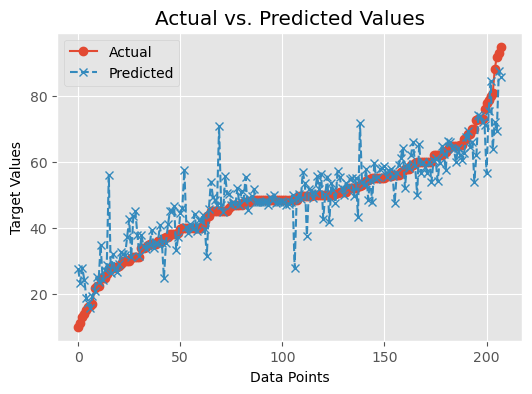

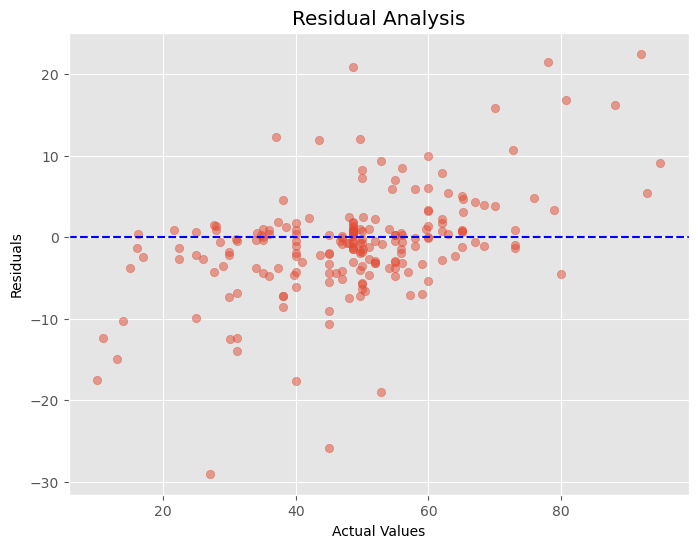

In [115]:
r2, mae, mse, rmse, y_pred = calculate_scores(best_estimator, X_test, y_test)
model_metrics = collect_data("XGB", r2, mae, mse, rmse, model_metrics)
print(f"R2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print_graph(y_test, y_pred) 
plot_residuals(y_test, y_pred)

R2: 0.9138177865174182, MAE: 2.760332232866607, MSE: 17.529565716051643, RMSE: 4.1868324203449605


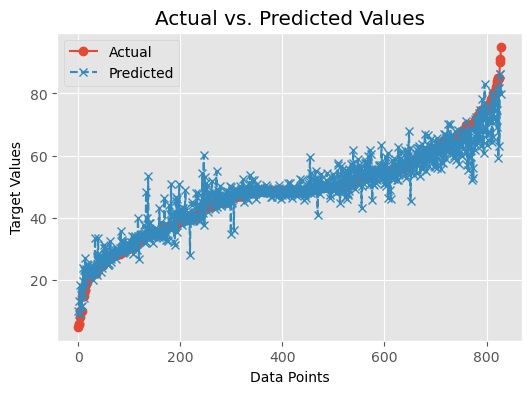

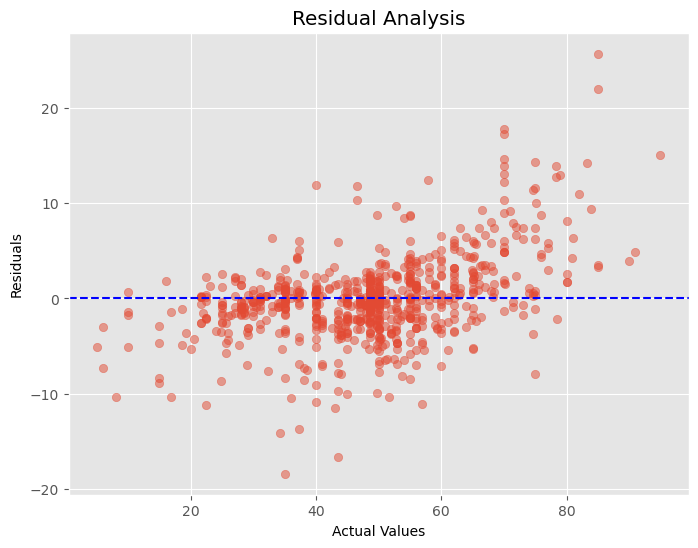

In [116]:
r2, mae, mse, rmse, y_pred = calculate_scores(best_estimator, X_train, y_train)
model_metrics = collect_data("XGB", r2, mae, mse, rmse, model_metrics)
print(f"R2: {r2}, MAE: {mae}, MSE: {mse}, RMSE: {rmse}")
print_graph(y_train, y_pred)
plot_residuals(y_train, y_pred)

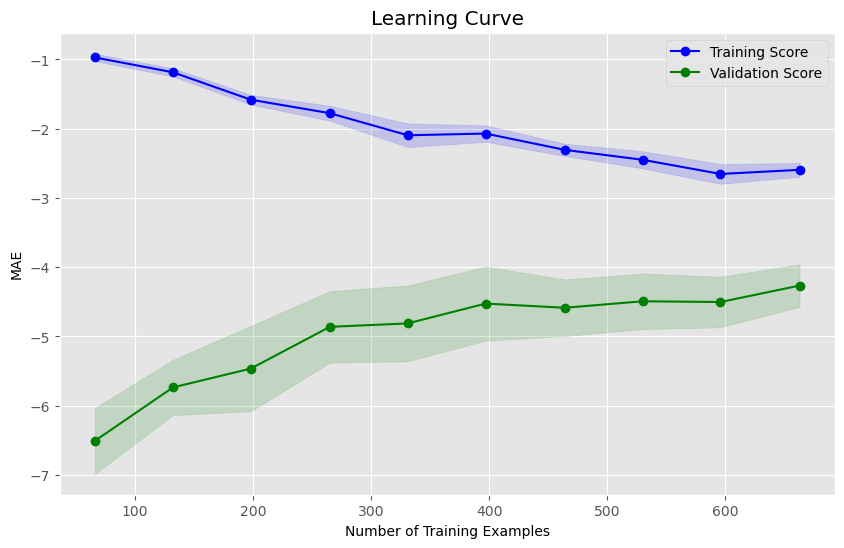

In [117]:
# Plot learning curves
plot_learning_curve(best_estimator, X_train, y_train, param_space, cv=kf, scoring='neg_mean_absolute_error')

# Models assessment <a class="anchor" id="section_11_1"></a>

In this section, we will use the previously calculated and collected R2, MAE, MSE and RMSE for both training and testing data for each model. Then we will calculate the MAE gap and turn the data into data frame. Based on this dataframe we will plot R2, MAE, MSE and RMSE comparissons for each model.

In [118]:
#Generat raw data base on model metrics
raw_data = {'RF - def': model_metrics['RF_def'],\
           'RF - tune': model_metrics['RF_tune'], \
           'RF - LASSO': model_metrics['RF_LASSO'],
           'SVR - def': model_metrics['SVR_def'],
           'SVR - tune': model_metrics['SVR_tune'], \
           'XGB': model_metrics['XGB']}

In [119]:
#Calculate MAE gaps
for k, v in raw_data.items():
    mae_gap = v[1] - v[5]
    raw_data[k].append(mae_gap)
model_assessment = pd.DataFrame.from_dict(raw_data, orient='index')

In [120]:
model_assessment

,0,1,2,3,4,5,6,7,8
RF - def,0.82,3.88,40.81,6.39,0.97,1.38,5.35,2.31,2.50
RF - tune,0.78,4.45,49.47,7.03,0.86,3.04,28.13,5.30,1.41
RF - LASSO,0.77,4.69,51.04,7.14,0.84,3.70,31.81,5.64,0.99
SVR - def,0.40,8.46,134.55,11.60,0.40,8.09,122.95,11.09,0.37
SVR - tune,0.69,5.32,69.24,8.32,0.64,5.06,72.42,8.51,0.26
XGB,0.81,4.17,42.54,6.52,0.91,2.76,17.53,4.19,1.41


In [121]:
#Add column names
model_assessment.columns = ['R2_test', 'MAE_test', 'MSE_test', 'RMSE_test',\
                          'R2_train', 'MAE_train', 'MSE_train', 'RMSE_train', 'MAE_gap']

In [122]:
model_assessment

,R2_test,MAE_test,MSE_test,RMSE_test,R2_train,MAE_train,MSE_train,RMSE_train,MAE_gap
RF - def,0.82,3.88,40.81,6.39,0.97,1.38,5.35,2.31,2.50
RF - tune,0.78,4.45,49.47,7.03,0.86,3.04,28.13,5.30,1.41
RF - LASSO,0.77,4.69,51.04,7.14,0.84,3.70,31.81,5.64,0.99
SVR - def,0.40,8.46,134.55,11.60,0.40,8.09,122.95,11.09,0.37
SVR - tune,0.69,5.32,69.24,8.32,0.64,5.06,72.42,8.51,0.26
XGB,0.81,4.17,42.54,6.52,0.91,2.76,17.53,4.19,1.41


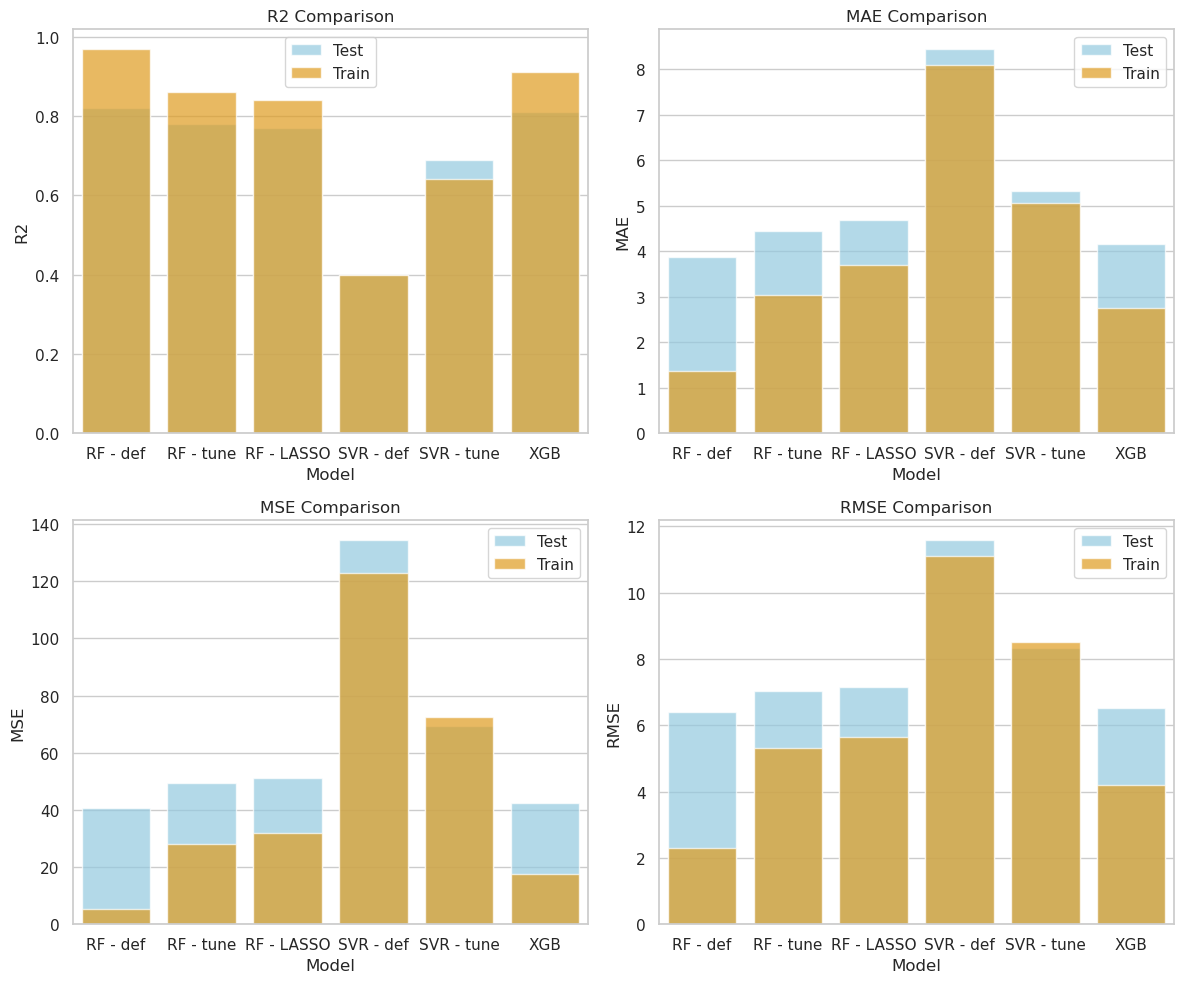

In [123]:
#Prepare bar plots
model_assessment['Model'] = ['RF - def', 'RF - tune', 'RF - LASSO', 'SVR - def', 'SVR - tune', 'XGB']

sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

metrics = ['R2', 'MAE', 'MSE', 'RMSE']

for i, metric in enumerate(metrics):
    row, col = divmod(i, 2)
    ax = axes[row, col]

    sns.barplot(x='Model', y=f'{metric}_test', data=model_assessment, ax=ax, color='skyblue', alpha=0.7, label='Test')
    sns.barplot(x='Model', y=f'{metric}_train', data=model_assessment, ax=ax, color='orange', alpha=0.7, label='Train')

    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(f'{metric}')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()

Considering the agregated metrics including 'R2', 'MAE', 'MSE', 'RMSE', we can see that XGB achieves the best results. This model has the lowest 'MAE', 'MSE', 'RMSE' on both training and testing data. The revision does not take into account the default RandomForest Regressor which has high variance and is not tuned. </br>
To ensure the model does not overfit, the following has taken place:
 - The number of trees has been limited
 - Max depth and learning rate have been set
 - Regularization has been applied by specifing gamma, alpha, lambda as well as number of samples
 - The model has been tested with different random_states to ensure the impact on the metrics is little to none.

# Resources  <a class="anchor" id="section_12_1"></a>

RandomForest:
 - __[sklearn.ensemble.RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)__
 - __["Random Forests" by Leo Breiman (2001)](https://link.springer.com/article/10.1023/A:1010933404324)__
 - __[Hyperparameters and Tuning Strategies for Random Forest](https://www.researchgate.net/publication/324438530_Hyperparameters_and_Tuning_Strategies_for_Random_Forest)__
 
Support Vector Regression:
 - __[sklearn.svm.SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)__
 - __[SVR kernels](https://scikit-learn.org/stable/auto_examples/svm/plot_svm_regression.html)__
 - __[House: Simple SVR(Support Vector Regression)](https://www.kaggle.com/code/himaoka/house-simple-svr-support-vector-regression)__
 - __[Support Vector Regression (SVR)](https://www.kaggle.com/code/nkhattri/support-vector-regression-svr)__
 
Plotting Learning Curves:
 - __[Plotting Learning Curves and Checking Models’ Scalability](https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)__
 - __[Learning Curve](https://www.valamis.com/hub/learning-curve)__
 - __[Using Learning Curves – ML)](https://www.geeksforgeeks.org/using-learning-curves-ml/)__
 
LASSO and Ridge:
 - __[Hyperparameter tuning using Ridge and Lasso Regression](https://ai-ml-analytics.com/Jupyter_notebook/Blog%20-%2020%20-%20Hyperparameter%20tuning%20using%20Ridge%20and%20Lasso%20Regression.html)__
 - __[Lasso and Ridge Hypertuning](https://www.kaggle.com/code/deepakdodi/lasso-and-ridge-hypertuning-over-gapminder-dataset)__
 - __[Regression Shrinkage and Selection via the Lasso)](https://webdoc.agsci.colostate.edu/koontz/arec-econ535/papers/Tibshirani%20(JRSS-B%201996).pdf)__
 
XGB:
 - __[XGBoost Documentation](https://xgboost.readthedocs.io/en/stable/)__
 - __[XGBoost: A Scalable Tree Boosting System](https://arxiv.org/abs/1603.02754)__
 - __[A Guide on XGBoost hyperparameters tuning)](https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning)__

# Closing notes  <a class="anchor" id="section_13_1"></a>

<b>Why this dataset ?</b>: For me as a begginner in the field of Machine Learning was important to check and see if I am able to work with a smaller dataset with a lot of missing values. It was interesting the explore the ways to generate a little more realistic data and this way fill the gaps. It could be interpreted as a way to get around the best case scenario where thousands and thousands of observations guarantee more success naturally.</br></br>
<b>The logic of filling the gaps in the dataset</b>: The project in its initial form was reworked a few times. In the end of each one of the experiments however, I never had a feeling that the result if good enough to be presented. This final version of the project reflects the result of my additional research where I found hidden relations between the existing features and this way managed to fill the gaps with a little more realistic data. </br></br>
<b>Domain knowledge</b>: Since I have zero information regarding roller coasters, I had to invest some time and effort in this direction. I wanted to be more confident when deciding what is an outlier and what not. I have a strong feeling that appling statistical approch without any domain knowledge is not good enough. </br></br>
<b>Why those algorithms</b>: After some initial research and tests I came to the conclusion that I need algorithms that are roubust to noisy data and also get advantage of "wisdom of the crowd". It was also worth testing model stacking and some more sophisticated approaches like XGB.  </br></br>
<b>Why BayesSearchCV rather than GridSearchCV or RandomSearchCV</b>: I needed a method that efficiently explores the parameter space, focusing on the most promising regions. While the other methods either test all combination or pick some randomly, BayesSearchCV adapts its search strategy based on the outcomes of previous evaluations